# Preprocessing the Text

## Imports


In [ ]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

from imblearn.over_sampling import SMOTE

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, SimpleRNN, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

## Load spacy model


In [ ]:
nlp = spacy.load("en_core_web_sm")
file_path = '/content/drive/MyDrive/DatasetsJuly/Spam_Detection.csv'
df = pd.read_csv(file_path)
df.head()

,Label,Mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Plot the distribution of labels

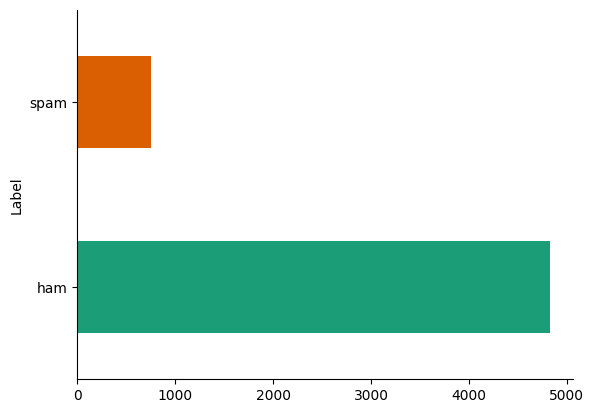

In [ ]:
df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Preprocess the text


In [ ]:
def preprocess_text_spacy(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text.lower())
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    doc = nlp(text  )

    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    abbreviations = {
        "u": "you",
        "r": "are",
        "ur": "your",
        "b4": "before",
        "gr8": "great",
        "l8r": "later",
    }
    tokens = [abbreviations.get(word, word) for word in tokens]

    return ' '.join(tokens)

In [ ]:
df['Processed_Mail'] = df['Mail'].apply(preprocess_text_spacy)

<ipython-input-12-53538d07ddce>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
df.to_csv('Preprocessed_Spam_Detection.csv', index=False)

## Reading the new preprocessed file

In [ ]:
print(pd.read_csv('/content/Preprocessed_Spam_Detection.csv').head())

  Label                                               Mail  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                      Processed_Mail  
0  jurong point crazy available bugis n great wor...  
1                            ok lar joke wif you oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                            you dun early hor you c  
4                          nah not think go usf live  


In [ ]:
print(df[['Label', 'Mail', 'Processed_Mail']])

     Label                                               Mail  \
0      ham  Go until jurong point, crazy.. Available only ...   
1      ham                      Ok lar... Joking wif u oni...   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3      ham  U dun say so early hor... U c already then say...   
4      ham  Nah I don't think he goes to usf, he lives aro...   
...    ...                                                ...   
5567  spam  This is the 2nd time we have tried 2 contact u...   
5568   ham               Will ü b going to esplanade fr home?   
5569   ham  Pity, * was in mood for that. So...any other s...   
5570   ham  The guy did some bitching but I acted like i'd...   
5571   ham                         Rofl. Its true to its name   

                                         Processed_Mail  
0     jurong point crazy available bugis n great wor...  
1                               ok lar joke wif you oni  
2     free entry 2 wkly comp win fa cup final

# Analyzing the Data

## Split the data into spam and non-spam

In [ ]:
spam_df = df[df['Label'] == 'spam']
ham_df = df[df['Label'] == 'ham']

## Function to get word frequencies

In [ ]:
def get_word_frequencies(texts):
    all_words = ' '.join(texts).split()
    return Counter(all_words)

In [ ]:
spam_word_freq = get_word_frequencies(spam_df['Processed_Mail'])
ham_word_freq = get_word_frequencies(ham_df['Processed_Mail'])
spam_word_freq, ham_word_freq

(Counter({'free': 217,
          'entry': 26,
          '2': 173,
          'wkly': 14,
          'comp': 10,
          'win': 131,
          'fa': 4,
          'cup': 5,
          'final': 16,
          'tkts': 4,
          '21st': 2,
          '2005': 3,
          'text': 137,
          '87121': 4,
          'receive': 36,
          'questionstd': 2,
          'txt': 159,
          'ratetcs': 2,
          'apply': 29,
          '08452810075over18s': 2,
          'freemsg': 12,
          'hey': 5,
          'darle': 1,
          '3': 31,
          'week': 60,
          'word': 22,
          'd': 8,
          'like': 13,
          'fun': 9,
          'tb': 1,
          'ok': 5,
          'xxx': 11,
          'std': 9,
          'chgs': 1,
          'send': 80,
          '150': 39,
          'rcv': 2,
          'winner': 16,
          'value': 11,
          'network': 27,
          'customer': 51,
          'select': 26,
          'receivea': 2,
          '900': 7,
          'prize': 92

In [ ]:
print("Most common words in spam emails:", spam_word_freq.most_common(10))
print("Most common words in non-spam emails:", ham_word_freq.most_common(10))

Most common words in spam emails: [('free', 217), ('2', 173), ('txt', 159), ('you', 145), ('your', 144), ('text', 137), ('mobile', 135), ('win', 131), ('4', 119), ('stop', 115)]
Most common words in non-spam emails: [('you', 985), ('not', 697), ('m', 470), ('go', 325), ('come', 321), ('2', 309), ('s', 307), ('get', 300), ('ok', 273), ('good', 260)]


## Plot word frequencies


In [ ]:
def plot_word_frequencies(word_freq, title):
    words, counts = zip(*word_freq.most_common(10))
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

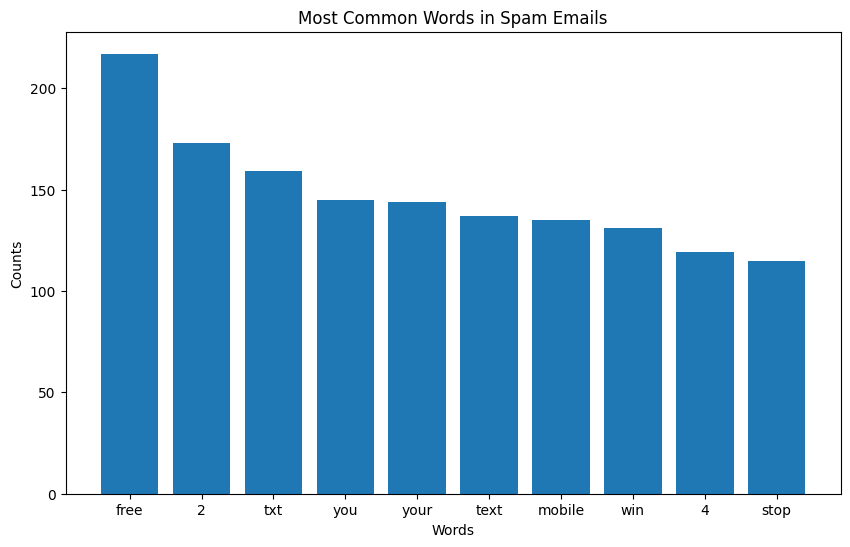

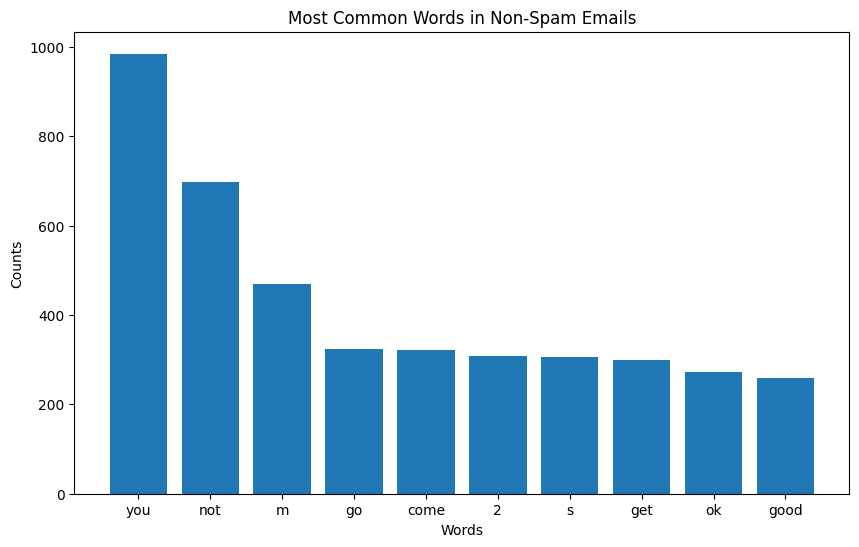

In [ ]:
plot_word_frequencies(spam_word_freq, 'Most Common Words in Spam Emails')
plot_word_frequencies(ham_word_freq, 'Most Common Words in Non-Spam Emails')

# Balancing the Data

## Split the data into features and labels

In [ ]:
X = df['Processed_Mail']
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0)

## Split into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head(), X_test.head()

(1978    reply win 100 weekly 2006 fifa world cup hold ...
 3989    hello sort town   not rush home eat nachos let...
 3935                         come guoyang n tell you tell
 4078    hey sathya till dint meet single time see situ...
 4086    orange bring ringtone time chart hero free hit...
 Name: Processed_Mail, dtype: object,
 3245    squeeeeeze christmas hug you lik frndshp den h...
 944     ve sorta blow couple time recently d text blue...
 1044    mmm s well get roast d b well drink 2 good indian
 2484                            mm kanji not eat heavy ok
 812     s ring come guy costume gift future yowife hin...
 Name: Processed_Mail, dtype: object)

## Vectorize the text data


In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
X_train_vec, X_test_vec

(<4457x7146 sparse matrix of type '<class 'numpy.int64'>'
 	with 33593 stored elements in Compressed Sparse Row format>,
 <1115x7146 sparse matrix of type '<class 'numpy.int64'>'
 	with 7324 stored elements in Compressed Sparse Row format>)

## Apply SMOTE


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

In [ ]:
X_train_res, y_train_res

(<7718x7146 sparse matrix of type '<class 'numpy.int64'>'
 	with 88896 stored elements in Compressed Sparse Row format>,
 0       1
 1       0
 2       0
 3       0
 4       1
        ..
 7713    1
 7714    1
 7715    1
 7716    1
 7717    1
 Name: Label, Length: 7718, dtype: int64)

## Check the balance of the resampled dataset

In [ ]:
print("Original dataset shape:", Counter(y))
print("Resampled dataset shape:", Counter(y_train_res))

Original dataset shape: Counter({0: 4825, 1: 747})
Resampled dataset shape: Counter({1: 3859, 0: 3859})


# Tokenization

## Prepare the data for RNN models

In [ ]:
max_words = 5000
max_len = 100

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

## Apply SMOTE again for padded sequences

In [ ]:
X_train_pad_res, y_train_res = smote.fit_resample(X_train_pad, y_train)

# Implementing Models

## LSTM

### Function to create LSTM model

In [ ]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Create and train the LSTM model


In [ ]:
lstm_model = create_lstm_model()
history = lstm_model.fit(X_train_pad_res, y_train_res, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2)

### Evaluate LSTM model

In [ ]:
y_pred = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

35/35 [==============================] - 1s 29ms/step
              precision    recall  f1-score   support

         ham       0.99      0.94      0.97       966
        spam       0.72      0.94      0.82       149

    accuracy                           0.94      1115
   macro avg       0.86      0.94      0.89      1115
weighted avg       0.95      0.94      0.95      1115



## RNN

### Function to create RNN model


In [ ]:
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Create and train the RNN model

In [ ]:
rnn_model = create_rnn_model()
history = rnn_model.fit(X_train_pad_res, y_train_res, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/5
121/121 - 26s - loss: 0.4626 - accuracy: 0.7770 - val_loss: 0.2585 - val_accuracy: 0.9004 - 26s/epoch - 218ms/step
Epoch 2/5
121/121 - 18s - loss: 0.2358 - accuracy: 0.9074 - val_loss: 0.1499 - val_accuracy: 0.9489 - 18s/epoch - 152ms/step
Epoch 3/5
121/121 - 17s - loss: 0.1459 - accuracy: 0.9488 - val_loss: 0.1192 - val_accuracy: 0.9570 - 17s/epoch - 139ms/step
Epoch 4/5
121/121 - 17s - loss: 0.1056 - accuracy: 0.9648 - val_loss: 0.0973 - val_accuracy: 0.9722 - 17s/epoch - 140ms/step
Epoch 5/5
121/121 - 18s - loss: 0.0686 - accuracy: 0.9785 - val_loss: 0.1055 - val_accuracy: 0.9713 - 18s/epoch - 149ms/step


### Evaluate RNN model


In [ ]:
y_pred = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

35/35 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.88      0.91      0.89       149

    accuracy                           0.97      1115
   macro avg       0.93      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115



## GRU

### Function to create GRU model


In [ ]:
def create_gru_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Create and train the GRU model

In [ ]:
gru_model = create_gru_model()
history = gru_model.fit(X_train_pad_res, y_train_res, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/5
121/121 - 48s - loss: 0.3630 - accuracy: 0.8314 - val_loss: 0.1567 - val_accuracy: 0.9516 - 48s/epoch - 400ms/step
Epoch 2/5
121/121 - 40s - loss: 0.1667 - accuracy: 0.9407 - val_loss: 0.1176 - val_accuracy: 0.9659 - 40s/epoch - 330ms/step
Epoch 3/5
121/121 - 38s - loss: 0.1074 - accuracy: 0.9648 - val_loss: 0.1270 - val_accuracy: 0.9587 - 38s/epoch - 314ms/step
Epoch 4/5
121/121 - 36s - loss: 0.0709 - accuracy: 0.9784 - val_loss: 0.1163 - val_accuracy: 0.9578 - 36s/epoch - 301ms/step
Epoch 5/5
121/121 - 37s - loss: 0.0503 - accuracy: 0.9860 - val_loss: 0.1413 - val_accuracy: 0.9561 - 37s/epoch - 308ms/step


### Evaluate GRU model

In [ ]:
y_pred = (gru_model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

35/35 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

         ham       0.99      0.96      0.97       966
        spam       0.77      0.96      0.85       149

    accuracy                           0.96      1115
   macro avg       0.88      0.96      0.91      1115
weighted avg       0.96      0.96      0.96      1115



# Optimizing the Model

Defining 3 optimizers and 3 learning rates

In [ ]:
optimizers = ['adam', 'sgd', 'rmsprop']
learning_rates = [0.001, 0.01, 0.1]

Training with all optimizers and all learning rates,
since there are 3 vs 3
we're going to train for 9 times to find the best model

In [ ]:
best_model = None
best_score = 0
for optimizer in optimizers:
    for lr in learning_rates:
        print(f"Training with optimizer {optimizer} and learning rate {lr}...")
        opt = tf.keras.optimizers.get(optimizer)
        opt.learning_rate = lr
        model = create_lstm_model()
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(X_train_pad_res, y_train_res, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2)

        score = model.evaluate(X_test_pad, y_test, verbose=0)[1]
        if score > best_score:
            best_score = score
            best_model = model

print("Best model accuracy:", best_score)

Training with optimizer adam and learning rate 0.001...
Epoch 1/5
121/121 - 51s - loss: 0.3520 - accuracy: 0.8414 - val_loss: 0.1329 - val_accuracy: 0.9614 - 51s/epoch - 425ms/step
Epoch 2/5
121/121 - 42s - loss: 0.1725 - accuracy: 0.9375 - val_loss: 0.1312 - val_accuracy: 0.9632 - 42s/epoch - 348ms/step
Epoch 3/5
121/121 - 42s - loss: 0.1139 - accuracy: 0.9627 - val_loss: 0.1341 - val_accuracy: 0.9525 - 42s/epoch - 346ms/step
Epoch 4/5
121/121 - 42s - loss: 0.0785 - accuracy: 0.9755 - val_loss: 0.1080 - val_accuracy: 0.9713 - 42s/epoch - 346ms/step
Epoch 5/5
121/121 - 42s - loss: 0.0598 - accuracy: 0.9812 - val_loss: 0.1564 - val_accuracy: 0.9561 - 42s/epoch - 343ms/step


Training with optimizer adam and learning rate 0.01...
Epoch 1/5
121/121 - 51s - loss: 0.2826 - accuracy: 0.8905 - val_loss: 0.1258 - val_accuracy: 0.9632 - 51s/epoch - 425ms/step
Epoch 2/5
121/121 - 42s - loss: 0.1115 - accuracy: 0.9602 - val_loss: 0.1220 - val_accuracy: 0.9659 - 42s/epoch - 349ms/step
Epoch 3/5
121/121 - 42s - loss: 0.0604 - accuracy: 0.9797 - val_loss: 0.1738 - val_accuracy: 0.9444 - 42s/epoch - 348ms/step
Epoch 4/5
121/121 - 41s - loss: 0.0386 - accuracy: 0.9886 - val_loss: 0.2397 - val_accuracy: 0.9444 - 41s/epoch - 342ms/step
Epoch 5/5
121/121 - 41s - loss: 0.0271 - accuracy: 0.9909 - val_loss: 0.1548 - val_accuracy: 0.9578 - 41s/epoch - 342ms/step


Training with optimizer adam and learning rate 0.1...
Epoch 1/5
121/121 - 51s - loss: 0.5325 - accuracy: 0.7438 - val_loss: 0.3454 - val_accuracy: 0.8404 - 51s/epoch - 418ms/step
Epoch 2/5
121/121 - 43s - loss: 0.4222 - accuracy: 0.8062 - val_loss: 0.3872 - val_accuracy: 0.8260 - 43s/epoch - 357ms/step
Epoch 3/5
121/121 - 42s - loss: 0.4239 - accuracy: 0.8016 - val_loss: 0.3477 - val_accuracy: 0.8619 - 42s/epoch - 345ms/step
Epoch 4/5
121/121 - 41s - loss: 0.4214 - accuracy: 0.8062 - val_loss: 0.3591 - val_accuracy: 0.8430 - 41s/epoch - 336ms/step
Epoch 5/5
121/121 - 42s - loss: 0.4169 - accuracy: 0.8103 - val_loss: 0.3929 - val_accuracy: 0.8314 - 42s/epoch - 343ms/step


Training with optimizer sgd and learning rate 0.001...
Epoch 1/5
121/121 - 46s - loss: 0.6958 - accuracy: 0.3877 - val_loss: 0.6979 - val_accuracy: 0.1982 - 46s/epoch - 384ms/step
Epoch 2/5
121/121 - 39s - loss: 0.6948 - accuracy: 0.4131 - val_loss: 0.6955 - val_accuracy: 0.2861 - 39s/epoch - 326ms/step
Epoch 3/5
121/121 - 40s - loss: 0.6939 - accuracy: 0.4558 - val_loss: 0.6934 - val_accuracy: 0.4807 - 40s/epoch - 330ms/step
Epoch 4/5
121/121 - 40s - loss: 0.6929 - accuracy: 0.5149 - val_loss: 0.6914 - val_accuracy: 0.6242 - 40s/epoch - 331ms/step
Epoch 5/5
121/121 - 41s - loss: 0.6921 - accuracy: 0.5526 - val_loss: 0.6894 - val_accuracy: 0.7076 - 41s/epoch - 337ms/step


Training with optimizer sgd and learning rate 0.01...
Epoch 1/5
121/121 - 45s - loss: 0.6869 - accuracy: 0.6682 - val_loss: 0.6712 - val_accuracy: 0.8529 - 45s/epoch - 375ms/step
Epoch 2/5
121/121 - 42s - loss: 0.6750 - accuracy: 0.7714 - val_loss: 0.6501 - val_accuracy: 0.8520 - 42s/epoch - 347ms/step
Epoch 3/5
121/121 - 40s - loss: 0.6550 - accuracy: 0.8252 - val_loss: 0.6100 - val_accuracy: 0.8448 - 40s/epoch - 333ms/step
Epoch 4/5
121/121 - 41s - loss: 0.6129 - accuracy: 0.8300 - val_loss: 0.5330 - val_accuracy: 0.8430 - 41s/epoch - 337ms/step
Epoch 5/5
121/121 - 40s - loss: 0.5366 - accuracy: 0.8317 - val_loss: 0.4821 - val_accuracy: 0.8233 - 40s/epoch - 332ms/step


Training with optimizer sgd and learning rate 0.1...
Epoch 1/5
121/121 - 46s - loss: 0.5677 - accuracy: 0.7600 - val_loss: 0.4575 - val_accuracy: 0.8018 - 46s/epoch - 381ms/step
Epoch 2/5
121/121 - 40s - loss: 0.4091 - accuracy: 0.8343 - val_loss: 0.3297 - val_accuracy: 0.8520 - 40s/epoch - 335ms/step
Epoch 3/5
121/121 - 40s - loss: 0.3994 - accuracy: 0.8354 - val_loss: 0.3480 - val_accuracy: 0.8430 - 40s/epoch - 327ms/step
Epoch 4/5
121/121 - 39s - loss: 0.3814 - accuracy: 0.8399 - val_loss: 0.3540 - val_accuracy: 0.8386 - 39s/epoch - 326ms/step
Epoch 5/5
121/121 - 40s - loss: 0.3620 - accuracy: 0.8497 - val_loss: 0.3245 - val_accuracy: 0.8547 - 40s/epoch - 327ms/step


Training with optimizer rmsprop and learning rate 0.001...
Epoch 1/5
121/121 - 47s - loss: 0.3611 - accuracy: 0.8453 - val_loss: 0.1930 - val_accuracy: 0.9408 - 47s/epoch - 389ms/step
Epoch 2/5
121/121 - 41s - loss: 0.2209 - accuracy: 0.9155 - val_loss: 0.1103 - val_accuracy: 0.9713 - 41s/epoch - 336ms/step
Epoch 3/5
121/121 - 40s - loss: 0.1743 - accuracy: 0.9379 - val_loss: 0.1395 - val_accuracy: 0.9605 - 40s/epoch - 332ms/step
Epoch 4/5
121/121 - 40s - loss: 0.1466 - accuracy: 0.9495 - val_loss: 0.1178 - val_accuracy: 0.9677 - 40s/epoch - 335ms/step
Epoch 5/5
121/121 - 40s - loss: 0.1236 - accuracy: 0.9593 - val_loss: 0.1423 - val_accuracy: 0.9587 - 40s/epoch - 332ms/step


Training with optimizer rmsprop and learning rate 0.01...
Epoch 1/5
121/121 - 48s - loss: 0.3388 - accuracy: 0.8561 - val_loss: 0.1131 - val_accuracy: 0.9677 - 48s/epoch - 401ms/step
Epoch 2/5
121/121 - 42s - loss: 0.1576 - accuracy: 0.9442 - val_loss: 0.2409 - val_accuracy: 0.9229 - 42s/epoch - 347ms/step
Epoch 3/5
121/121 - 42s - loss: 0.1044 - accuracy: 0.9653 - val_loss: 0.1346 - val_accuracy: 0.9561 - 42s/epoch - 346ms/step
Epoch 4/5
121/121 - 41s - loss: 0.0633 - accuracy: 0.9808 - val_loss: 0.2191 - val_accuracy: 0.9336 - 41s/epoch - 343ms/step
Epoch 5/5
121/121 - 40s - loss: 0.0482 - accuracy: 0.9854 - val_loss: 0.1815 - val_accuracy: 0.9534 - 40s/epoch - 334ms/step


Training with optimizer rmsprop and learning rate 0.1...
Epoch 1/5
121/121 - 47s - loss: 1.0622 - accuracy: 0.5868 - val_loss: 0.3796 - val_accuracy: 0.8287 - 47s/epoch - 387ms/step
Epoch 2/5
121/121 - 41s - loss: 0.4820 - accuracy: 0.7939 - val_loss: 0.2994 - val_accuracy: 0.8744 - 41s/epoch - 339ms/step
Epoch 3/5
121/121 - 41s - loss: 0.4616 - accuracy: 0.7945 - val_loss: 0.5196 - val_accuracy: 0.7668 - 41s/epoch - 341ms/step
Epoch 4/5
121/121 - 41s - loss: 0.4824 - accuracy: 0.7753 - val_loss: 0.3777 - val_accuracy: 0.8368 - 41s/epoch - 339ms/step
Epoch 5/5
121/121 - 40s - loss: 0.4813 - accuracy: 0.7756 - val_loss: 0.5130 - val_accuracy: 0.7641 - 40s/epoch - 334ms/step
Best model accuracy: 0.9587444067001343


## Saving the best model
**run this cell only of you are training from the beginning !!**

In [ ]:
best_model.save('best_spam_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Accuracy, Precision, Recall, and F1-score
of the best model,
***if not avalible just load it from the next cell***

In [ ]:
print("Test Set Evaluation:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test, target_names=['ham', 'spam']))

Test Set Evaluation:

Accuracy: 0.9587443946188341
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.96      0.98       966
        spam       0.79      0.95      0.86       149

    accuracy                           0.96      1115
   macro avg       0.89      0.95      0.92      1115
weighted avg       0.96      0.96      0.96      1115



## Load and evaluate the best model

In [ ]:
loaded_model = tf.keras.models.load_model('best_spam_detection_model.h5')

In [ ]:
loaded_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 128)          640000    
                                                                 
 spatial_dropout1d_9 (Spati  (None, 100, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_7 (LSTM)               (None, 100)               91600     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 731701 (2.79 MB)
Trainable params: 731701 (2.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
y_pred_test = (loaded_model.predict(X_test_pad) > 0.5).astype("int32")

35/35 [==============================] - 1s 31ms/step


In [ ]:
print("Test Set Evaluation:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test, target_names=['ham', 'spam']))

Test Set Evaluation:

Accuracy: 0.9587443946188341
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.96      0.98       966
        spam       0.79      0.95      0.86       149

    accuracy                           0.96      1115
   macro avg       0.89      0.95      0.92      1115
weighted avg       0.96      0.96      0.96      1115



## Confusion Matrix Plot

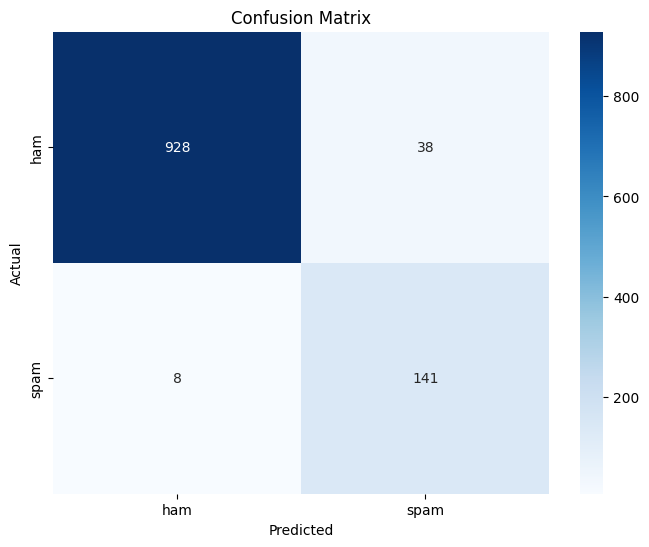

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()